This code is hosted at: https://github.com/MaxOliveberg/optimal-control-homeworks/blob/master/homework_2/solution.ipynb


This first cell contains code that was originally contained in a separate file, definitions.py. It needs to be run first.

In [35]:
import dataclasses
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optim

def psi(s):
    return 3 * (s ** 3) - 14 * (s ** 2) + 20 * s - 8


@dataclasses.dataclass
class Circle:
    point: np.ndarray
    radius: float


@dataclasses.dataclass
class Config:
    k: float = 1.0
    d: float = 1.0
    epsilon: float = 1.0
    T: float = 4
    dt: float = 0.1
    basis_N: int = 1
    distance_scaling: float = 1.0
    x_l: np.ndarray = np.array([2, 2])
    x_f: np.ndarray = np.array([1, 2])
    x_e: np.ndarray = np.array([5, 0])
    psi: Callable[[float], float] = psi
    circles: list[Circle] = None

    @property
    def x0(self) -> np.ndarray:
        ret = np.zeros(4)
        ret[:2] = self.x_f
        ret[2:] = self.x_l
        return ret

    @property
    def N(self) -> int:
        return int(self.T / self.dt)

    def g(self, beta: np.ndarray):
        beta_norm = np.sqrt(beta.dot(beta))
        if beta_norm <= self.d:
            return self.k * beta
        elif self.d < beta_norm <= self.d + self.epsilon:
            return self.psi(beta_norm) * (beta / beta_norm)
        else:
            return np.zeros(2)

    def f(self, x: np.ndarray, u: np.ndarray):
        """
        We use the convention x = [x_f, x_l] is a 4-vector, u = [u_x, u_y] is a 2-vector.
        """
        ret = np.zeros(4)
        ret[:2] = self.g(x[2:] - x[:2])
        ret[2:] = u
        return ret

    def f_0(self, x: np.ndarray, u: np.ndarray):
        return u.dot(u)

    def phi(self, x: np.ndarray):
        diff = x[:2] - self.x_e
        return diff.dot(diff)


def split_result(x: np.ndarray, config: Config):
    ret_f = []
    ret_l = []
    for k in range(config.N):
        ret_f.append(x[4 * k:4 * k + 2])
        ret_l.append(x[4 * k + 2: 4 * (k + 1)])
    return np.array(ret_f).transpose(), np.array(ret_l).transpose()


def plot_results(results, config):
    follower, leader = split_result(results.x, config)
    plt.plot(follower[0, :], follower[1, :], label="Follower Trajectory")
    plt.plot(leader[0, :], leader[1, :], label="Leader Trajectory")
    plt.scatter([config.x_f[0]], [config.x_f[1]], label="Follower initial state")
    plt.scatter([config.x_l[0]], [config.x_l[1]], label="Leader initial state")
    plt.scatter([config.x_e[0]], [config.x_e[1]], label="Exit")

    if config.circles is not None:
        for c in config.circles:
            thetas = np.arange(0, 2 * np.pi, 0.1)
            x_s = c.radius * np.cos(thetas) + c.point[0]
            y_s = c.radius * np.sin(thetas) + c.point[1]
            plt.plot(x_s, y_s, linestyle="--", color="black")

    plt.legend()


def plot_signal(u, config):
    times = np.arange(1, config.N + 1) * config.dt
    u = u.reshape(-1, 2).transpose()
    plt.plot(times, u[0, :], label="u_x")
    plt.plot(times, u[1, :], label="u_y")
    plt.legend()
    plt.xlabel("Time")


------- PROBLEM 1 --------


We are studying a scenario where a leader needs to lead a follower to an exit. We control the dynamics of the leader directly via our signal:
$$
\dot x_l = u.
$$
The follower travels towards the leader according to some function:
$$
\dot x_f = g(x_l - x_f).
$$
We will use the convention
$$
x := \begin{bmatrix}x_f \\ x_l\end{bmatrix}, \ \dot x = \begin{bmatrix}g(x_l - x_f) \\ u\end{bmatrix} =: f(x, u).
$$
We are penalised for expending the leaders energy via 
$$
f_0 = \vert u(t) \vert^2.
$$
The goal is to minimise the square distance from the exit at the terminal time $T$: 
$$
\phi(x_T) = \vert x_f(T) - x_{exit} \vert.
$$
Thus, the optimisation problem can be stated as
$$
\min \vert x_f(T) - x_{exit} \vert + \big( \int_0^T dt \big) \vert u(t) \vert^2 ,
$$
subject to $\dot x_f = g(x_l - x_f)$, $\dot x_l = u$, $x_f, x_l, u \in R^2$ and $x_l(0), x_f(0)$ given. The Hamiltonian is 
$$
H(t,x,u,\lambda) = f_0(t,x,u) + \lambda^T f(t,x,u) = \vert u(t) \vert ^2 + \lambda^T \begin{bmatrix}g(x_l - x_f) \\ u\end{bmatrix}.
$$
The point-wise optimisation problem is 
$$
u^* (t,x,\lambda) = \arg \min_{u\in U} H(t,x,u,\lambda).
$$
We state the two-point boundary value problem as 
$$
\dot \lambda(t) = -H_x(t, x, u^*, \lambda), \ \lambda(T) - \frac{\partial \phi}{\partial x}\big(T, x(T)\big) \perp S_f (T),
$$
and 
$$
\dot x(t) = H_\lambda ( y, x, u^*. \lambda) = [1, 1,1,1] \begin{bmatrix}g(x_l - x_f) \\ u\end{bmatrix}, \ x(t_0) = \begin{bmatrix}x_f \\ x_l\end{bmatrix}, \ x(T) \in S_f(T)= R^4. 
$$
------- PROBLEM 2 ---------

I have created a 'Config' object to hold all the parameters of the model. First we initialise the parameters for the problem:

In [14]:
config = Config()
config.dt = 0.1
config.T = 4
config.basis_N = 10

Let $x = [x_f^T, x_l^T]^T$. We have that the final penalty is 
$$
\phi(x_f) = \vert x_f(t_f) - x_e \vert^2,
$$
the running penalty function is 
$$
f_0(x, u) = \vert u \vert ^2,
$$
and the dynamics are given by 
$$
\dot x_f= g(x_f - x_l), \ \dot x_l = u.
$$
We can state the Hamiltonian $H$ as 
$$
H = \bar \lambda^T \bar f = f_0 \lambda_0 + \lambda^T f, \ \lambda_0 = 1.
$$

 First, I want to solve the problem by discretisation. We introduce some timestep $dt$, and the problem becomes
$$\min \phi(x_N) +  dt\sum_{k = 0}^N f_0 $$
subject to $x_{k+1} = x_k + fdt$, $x_0$ given and $G(x_N) = 0$. We introduce the notation 
$$
y = [x_1^T, ..., x_N^T, u_0, ..., u_{N-1}]^T,
$$
$$
F(y) = \phi(x_N) +  dt\sum_{k = 0}^N f_0,
$$
$$
G(y) = \begin{bmatrix} 
x_1 - (x_0 + dt f(0, x_0, u_0) \\ 
... \\
x_N - (x_{N-1} + dt f\big( dt(N-1), x_{N-1}, u_{N-1}\big)
\end{bmatrix}
$$
Then, we optimise 
$$
\min F(y) \ subj. \ G(y) = 0.
$$
I chose to do this with SciPy and Non-Linear Constraints. It's possible that a more clever mind could do the optimisation with linear constraints, but I haven't thought about it.

In [15]:

def G(y, config: Config):
    # The dynamics constraint, G
    ret = np.zeros(4 * config.N)
    x = y[:config.N * 4]
    u = y[4 * config.N:]
    for k in range(config.N):
        # This is faster to code than some matrix operation. System is so small that we
        # do not need to worry about compute
        x_0 = config.x0 if k == 0 else x[4 * (k - 1): 4 * k]
        x_1 = x[4 * k: 4 * (k + 1)]
        u_0 = u[2 * k: 2 * (k + 1)]
        ret[4 * k: 4 * (k + 1)] = x_1 - (x_0 + config.dt * config.f(x_0, u_0))
    return ret


def generate_G_condition(config: Config):
    # Returns a non-linear constraint representation of G
    G_local = lambda y: G(y, config)
    bound = np.zeros(4 * config.N)
    return optim.NonlinearConstraint(fun=G_local, lb=bound, ub=bound)


def F(y, config: Config):
    # The function to optimise
    x = y[:config.N * 4]
    u = y[config.N * 4:]
    ret = config.phi(x[-4:]) * config.distance_scaling # Final penalty
    for k in range(config.N):
        x_local = config.x0 if k == 0 else x[4 * (k - 1):4 * k]
        ret += config.dt * config.f_0(x_local, u[2 * k: 2 * (k + 1)])
    return ret


def get_initial_guess(config: Config):
    """
    Returns a vector corresponding to standing still for the whole simulation
    """
    ret = np.zeros(6 * config.N)
    for k in range(config.N):
        ret[4 * k:4 * (k + 1)] = config.x0
    return ret



Now that the code is in place, we can run the optimisation:

In [16]:
initial_guess = get_initial_guess(config)
to_optimise = lambda y: F(y, config)
constr = generate_G_condition(config)
results = optim.minimize(to_optimise, constraints=constr, x0=initial_guess)
print(results)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.681040531603613
       x: [ 1.100e+00  2.000e+00 ...  3.501e-04 -2.481e-04]
     nit: 17
     jac: [ 0.000e+00  0.000e+00 ...  7.004e-05 -4.959e-05]
    nfev: 4097
    njev: 17


Now we can have a look at the resulting trajectory: 

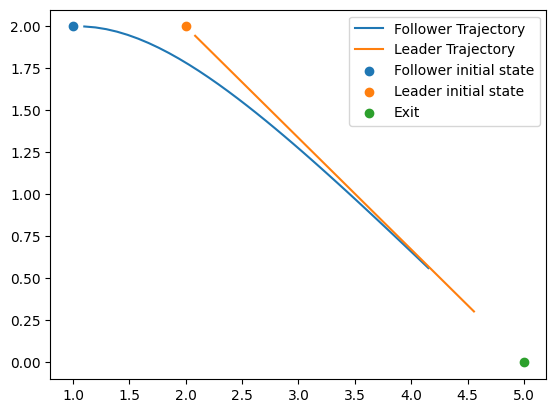

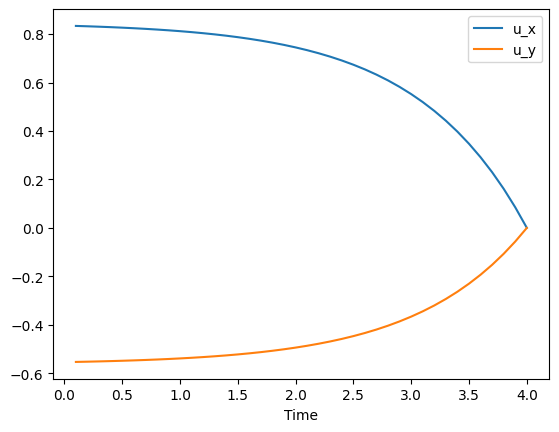

In [17]:
plot_results(results, config)
plt.figure()
plot_signal(results.x[config.N * 4:], config)

Now we approximate a solution using consistent approximation. We use the basis suggested in the problem statement: 

In [18]:
def basis(x, n):
    if n == 0:
        return 1 / 2
    if n % 2 == 0:
        return (np.sqrt(1 / 2) * np.cos((n / 2) * (np.pi * x / 2)))
    return (np.sqrt(1 / 2) * np.sin((np.floor(n / 2)) * (np.pi * x / 2)))


def signal_1d(x, weights):
    ret = 0
    for i, k in enumerate(weights):
        ret += k * basis(x, i)
    return ret


def signal(t, u):
    # Calculates the signal for time t given weights u
    u = u.reshape(-1, 2).transpose()
    return np.array([signal_1d(t, u[0, :]), signal_1d(t, u[1, :])])


The signal $u(t)$ can be decomposed as 
$$
u(t) = \sum u_k \phi(t).
$$
We have $\dot x = f(x, u)$ or 
$$
x = x_0 + \int dt \Big( f(x,u) \Big).
$$
Here we will solve the problem by discretising the integral. Previously, we optimised to obtain 
$$ 
y_{old} = [x_1^T, ... , x_{N}^T, u_0^T, ..., u_{N-1}^T].
$$
Now, we instead put
$$
u(t) = [ \sum u_{0, k} \phi(t), \sum u_{1, k} \phi(t)]^T.
$$
If we define $u_k = [u_{0,k}, u_{1,k}]^T$, and we truncate the basis at $K$, then our new state is 
$$
y_{new} = [x_1^T, ... , x_{N}^T, u_1^T, ..., u_{K}^T].
$$
However, we can transform the new state to the old, and reuse the previous code. This is done by taking $y_{new}$ and calculating $u(t)$, then arranging these in order to obtain $y_{old}$:

In [19]:
def new_2_old(y, config):
    new_vector = np.zeros(6 * config.N)
    new_vector[:4 * config.N] = y[:4 * config.N]
    coefs = y[4 * config.N:]
    for k in range(config.N):
        t = (k + 1) * config.dt
        new_vector[4 * config.N + (2 * k): 4 * config.N + (2 * (k + 1))] = signal(t, coefs)
    return new_vector

A few simple wrappers for the old code: 

In [20]:
def G_new(y: np.ndarray, config: Config):
    return G(new_2_old(y, config), config)


def F_new(y, config):
    return F(new_2_old(y, config), config)


def generate_new_G_condition(config: Config):
    # Returns a non-linear constraint representation of new G
    G_local = lambda y: G_new(y, config)
    bound = np.zeros(4 * config.N)
    return optim.NonlinearConstraint(fun=G_local, lb=bound, ub=bound)


def get_new_initial_guess(config: Config):
    return get_initial_guess(config)[:config.N * 4 + config.basis_N * 2]

Now we are ready to optimise! If you are viewing this as a notebook, you can change the truncation of the basis by changing 'basis_N' $= K$.

In [21]:

config.basis_N = 10 # Change me to try a larger/smaller basis!

initial_guess = get_new_initial_guess(config)
to_optimise = lambda y: F_new(y, config)
constr = generate_new_G_condition(config)
results_new = optim.minimize(to_optimise, constraints=constr, x0=initial_guess)
print(results_new)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.7291793892188023
       x: [ 1.100e+00  2.000e+00 ...  8.961e-02 -5.934e-02]
     nit: 16
     jac: [ 0.000e+00  0.000e+00 ...  1.792e-01 -1.187e-01]
    nfev: 2896
    njev: 16


We get a similar trajectory to the discrete method. However, if we look at the signal we can see the sinusoidal basis at work. 

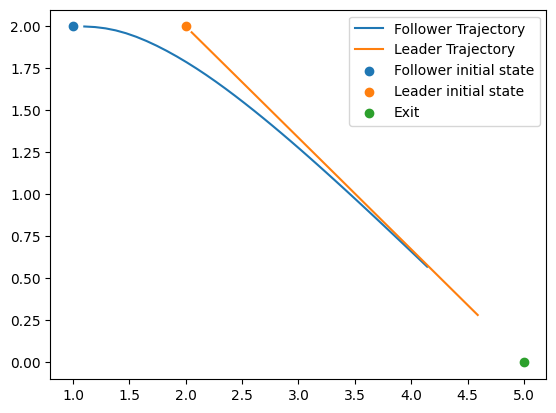

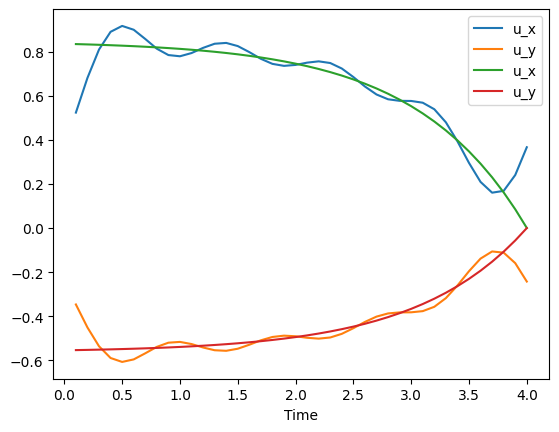

In [22]:
plot_results(results_new, config)
plt.figure()
plot_signal(new_2_old(results_new.x, config)[config.N * 4:], config)
plot_signal(results.x[config.N * 4:], config)

----PROBLEM 3-----

We place the leaders initial state at $x_l = [4,4]^T$

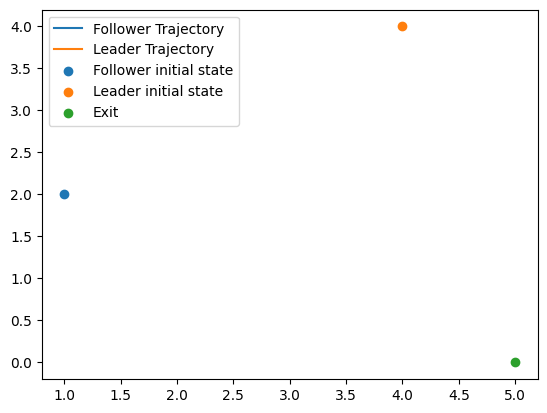

In [13]:
config_3 = Config()
config_3.x_l = np.array([4, 4])
initial_guess = get_initial_guess(config_3)
to_optimise = lambda y: F(y, config_3)
constr = generate_G_condition(config_3)
results_3 = optim.minimize(to_optimise, constraints=constr, x0=initial_guess)
plot_results(results_3, config_3)

The result is that the leader does not lead at all. This is probably due to requiring too much 'energy' to fetch the follower. We are tasked with finding two more local optima. Obviously, $x_f = x_e$, with $\vert x_f - x_l \vert > d+\epsilon$ is a local maxima (if not global!) It's possible that we can find a breakpoint where the agent starts moving. Lets attempt $x_e = [0,0]$, $x_l = [x, 0]$ and $x_f = [-x, 0]$ for some $x$.



In [23]:
config_4 = Config()
x = config.d - 10**(-3) # Change me!
config_4.x_l = np.array([x, 0])
config_4.x_f = np.array([-x, 0])
config_4.x_e = np.zeros(2)

initial_guess = get_initial_guess(config_4)
to_optimise = lambda y: F(y, config_4)
constr = generate_G_condition(config_4)
results_4 = optim.minimize(to_optimise, constraints=constr, x0=initial_guess)

At $x = 1$, the leader stands still. At $x < 0$, the leader begins making moves to save the follower. There is a numerical error on the order of $\sim 10^{-8}$.

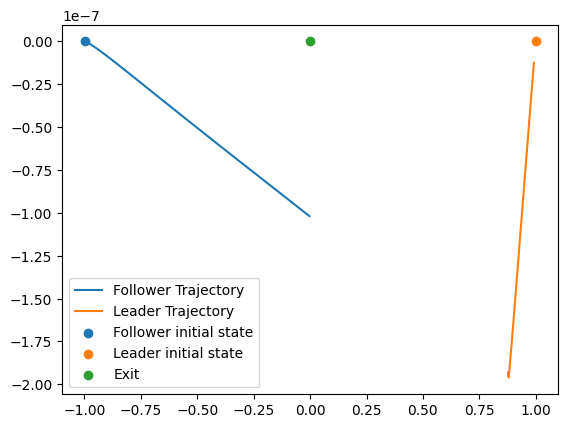

In [24]:
plot_results(results_4, config_4)

----- PROBLEM 4------

The final part of the assignment is to extend the problem so that it is more realistic. We do this by adding some obstacles that the agents can not cross. An obstacle is a circle which the agent can not pass through. Let $B_p(r) \subset R^2$ be the circle of radius $r$ centered at $p$. If $x_i$ is the coordinates of either the leader or follower, and $dx_i$ is their intended move then we require
$$
\vert x_i + dx_i - p \vert > r.
$$
A circle is chosen because it is faster to implement than a box. If we were not so lazy, we could state a similar constraint for boxes or triangles. The circle is most easily implemented as a non-linear constraint in SciPy:


In [25]:
def G_circle(y: np.ndarray, config: Config):
    states = y[:4 * config.N].reshape(-1, 2).transpose()
    ret = np.zeros(2 * config.N * len(config.circles))
    for c in range(len(config.circles)):
        for j in range(2 * config.N):
            i = c * 2 * config.N + j
            dx = states[:, j] - config.circles[c].point
            ret[i] = np.sqrt(dx.dot(dx))
    return ret


def get_G_circle(config: Config):
    ub = np.infty * np.ones(2 * config.N * len(config.circles))
    lb = np.zeros(2 * config.N * len(config.circles))
    for i, c in enumerate(config.circles):
        lb[2 * config.N * i:2 * config.N * (i + 1)] = c.radius
    g_lambda = lambda y: G_circle(y, config)
    return optim.NonlinearConstraint(g_lambda, lb=lb, ub=ub)

Further, I have added some scaling $s$ to the final cost. 
$$
\phi' = s\phi.
$$
This is so that I can increase it if I want to run a specific scenario, but the system is in a local minimum where both agents stand still.

In [31]:


config_4 = Config()

config_4.x_e = np.array([0, 0])
config_4.x_f = np.array([5, 0])
config_4.x_l = np.array([4, 0])
config_4.circles = [Circle(point=np.array([1, 0]), radius=0.1)]
config_4.distance_scaling = 10

initial_guess = get_initial_guess(config_4)

to_optimise = lambda y: F(y, config_4)
constr_1 = generate_G_condition(config_4)
constr_2 = get_G_circle(config_4)
results_4 = optim.minimize(to_optimise, constraints=[constr_1, constr_2], x0=initial_guess)

Time to look:

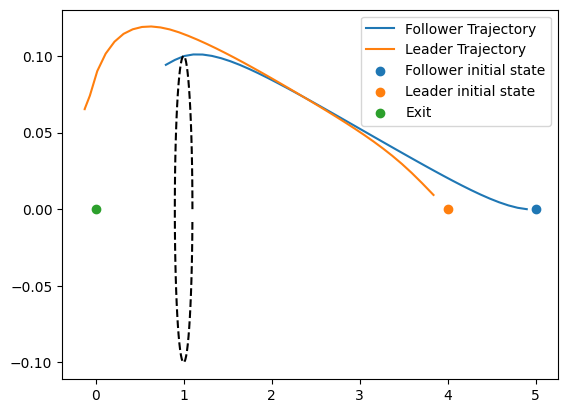

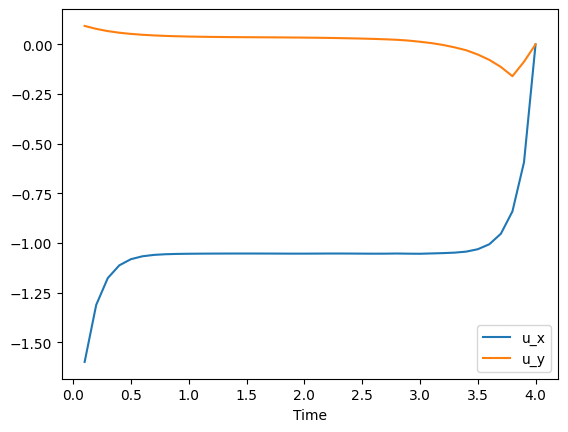

In [32]:
plot_results(results_4, config_4)
plt.figure()
plot_signal(results_4.x[config_4.N*4:], config_4)

Pretty cool!